Este caderno Jupyter se dedica a criar uma base sintética de benefícios do INSS contendo algumas fraudes. O caso foi baseado em um caso descrito da seguinte forma:

"A fraude foi detectada a partir de uma análise encaminhada pelo INSS. A PF disse também que o servidor investigado reativou temporariamente benefícios cessados por morte, alterando tanto o motivo da interrupção quanto os dados do titular, para receber os valores das aposentadorias na conta dele."
fonte: https://g1.globo.com/pe/pernambuco/noticia/2023/07/04/servidor-do-inss-e-investigado-por-ressuscitar-beneficiarios-mortos-e-desviar-dinheiro-de-aposentadorias.ghtml.


A base sintética possui as seguintes entidades com suas respectivas colunas:

Tabela de servidores:
- id_servidor: Matrícula do servidor concedente (0,1,2,...)
- uf_servidor: Unidade da Federação do servidor concedente (AC, AL, AP, ...)

Tabela de benefícios:
- id_beneficio: Número do Benefício (0,1,2,...)
- uf_beneficiario: Unidade da Federação do beneficiário  (AC, AL, AP, ...)
- id_servidor: Matrícula do servidor concedente
- uf_servidor: Unidade da Federação do servidor concedente (AC, AL, AP, ...)
- uf_coincidente: Indicação se a UF do servidor e do beneficiário é igual (true/false)
- reativado: Indicação se o benefício foi reativado (true/false);
- valor_beneficio: Valor do benefício.
- tempo_analise: Tempo de análise.


In [ ]:
# prompt: Gere a tabela de servidores, contendo 500 registros.
# Salve em um dataframe servidores e em um arquivo servidores.csv

import pandas as pd
import numpy as np

# Define a seed for reproducibility
np.random.seed(42)

# Number of server records
n_servers = 500

# Create a list of Brazilian states
ufs = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']

# Generate server data
data = {
    'id_servidor': range(n_servers),
    'uf_servidor': np.random.choice(ufs, size=n_servers)
}

# Create the DataFrame
servidores = pd.DataFrame(data)

# Save the DataFrame to a CSV file
servidores.to_csv('servidores.csv', index=False)

# Display the first 5 rows of the DataFrame
print(servidores.head())


   id_servidor uf_servidor
0            0          DF
1            1          RN
2            2          PB
3            3          MT
4            4          ES


In [ ]:
# prompt: Gere a tabela de benefícios, contendo 100.000 registros.
# Salve em um dataframe beneficios e em um arquivo beneficios.csv
# Use a seguinte distribuição nas seguintes colunas:
# uf_coincidente: verdadeiro em 90% das vezes
# reativado: verdadeiro em 5% das vezes
# valor_beneficio: log-normal (média=log(2000), std=0.1)
# tempo_analise: gamma(alpha=3, scale=1)+5+valor_beneficio/1000+reativado*2
# Considere que 20 servidores são fraudadores. Desses, 3% dos benefícios são fraudados.
# Os benefícios fraudados possuem outras características:
# uf_coincidente: verdadeiro em 99% das vezes
# reativado: sempre verdadeiro
# valor_beneficio: log-normal (média=log(2500), std=0.05)
# tempo_analise: gamma(alpha=2, scale=1)+8
# insira dos dados gerados uma coluna "fraude" indicando se o benefício foi fraudado ou não (true/false)

import pandas as pd
import numpy as np

# Define a seed for reproducibility
np.random.seed(42)

# Number of benefit records
n_beneficios = 100000

# Generate benefit data
data = {
    'id_beneficio': range(n_beneficios),
    'uf_beneficiario': np.random.choice(ufs, size=n_beneficios),
    'id_servidor': np.random.choice(range(n_servers), size=n_beneficios),
    'uf_coincidente': np.random.choice([True, False], size=n_beneficios, p=[0.9, 0.1]),
    'reativado': np.random.choice([True, False], size=n_beneficios, p=[0.05, 0.95]),
    'valor_beneficio': np.random.lognormal(mean=np.log(2000), sigma=0.1, size=n_beneficios),
    'fraude': np.random.choice([True,False], size=n_beneficios, p=[0.00,1.0])
}

# Create the DataFrame
beneficios = pd.DataFrame(data)

# Simulate fraudulent benefits
n_fraudulent_servers = 20
fraudulent_server_ids = np.random.choice(range(n_servers), size=n_fraudulent_servers, replace=False)
fraud_rate = 0.03

for i in range(n_beneficios):
  if beneficios.loc[i,'id_servidor'] in fraudulent_server_ids:
    if np.random.rand() < fraud_rate:
        beneficios.loc[i, 'fraude'] = True
        beneficios.loc[i, 'uf_coincidente'] = np.random.choice([True, False], p=[0.99, 0.01])
        beneficios.loc[i, 'reativado'] = True
        beneficios.loc[i, 'valor_beneficio'] = np.random.lognormal(mean=np.log(2500), sigma=0.05)


# Calculate tempo_analise
beneficios['tempo_analise'] = np.random.gamma(shape=3, scale=1, size=n_beneficios) + 5 + beneficios['valor_beneficio'] / 1000 + beneficios['reativado'] * 2
for i in range(n_beneficios):
  if beneficios.loc[i,'fraude']:
    beneficios.loc[i, 'tempo_analise'] = np.random.gamma(shape=2, scale=1) + 8
# Save the DataFrame to a CSV file
beneficios.to_csv('beneficios.csv', index=False)


In [ ]:
# prompt: Faça uma análise descritiva sobre todos os servidores, criando um novo dataframe com as seguintes colunas:
# id_servidor: Matrícula do servidor concedente
# num_beneficios: número de benefícios concedido por cada servidor
# percentual_reativado: percentual de reativações por servidor
# percentual_uf_coincidente: percentual de UFs coincidentes entre servidor e beneficiário
# media_valor: valor médio do benefício por servidor
# media_tempo: tempo médio de análise por servidor
# fraude: indicação se o servidor cometeu alguma fraude (true/false)
# Salve em um dataframe analise_servidores e em um arquivo analise_servidores.csv

import pandas as pd
import numpy as np

# Load the datasets
servidores = pd.read_csv('servidores.csv')
beneficios = pd.read_csv('beneficios.csv')

# Merge dataframes
merged_df = pd.merge(servidores, beneficios, on='id_servidor', how='inner')

# Group data by server
analise_servidores = merged_df.groupby('id_servidor').agg(
    num_beneficios=('id_beneficio', 'count'),
    percentual_reativado=('reativado', lambda x: (x.sum() / len(x)) * 100 if len(x) > 0 else 0),
    percentual_uf_coincidente=('uf_coincidente', lambda x: (x.sum() / len(x)) * 100 if len(x) > 0 else 0),
    media_valor=('valor_beneficio', 'mean'),
    media_tempo=('tempo_analise', 'mean'),
    fraude=('fraude', 'max')
).reset_index()

# Fill NaN values with False for fraude column (assuming no fraud if no benefits)
analise_servidores['fraude'] = analise_servidores['fraude'].fillna(False)

# Rename columns for clarity
analise_servidores = analise_servidores.rename(columns={'id_servidor': 'id_servidor'})

#Save to CSV
analise_servidores.to_csv('analise_servidores.csv', index=False)

print(analise_servidores.head())


   id_servidor  num_beneficios  percentual_reativado  \
0            0             202              3.960396   
1            1             200              4.500000   
2            2             192             10.937500   
3            3             219              2.283105   
4            4             192              6.250000   

   percentual_uf_coincidente  media_valor  media_tempo  fraude  
0                  94.059406  1988.223945    10.192713   False  
1                  85.000000  2023.539196    10.092463   False  
2                  86.458333  2023.542483     9.962347    True  
3                  89.954338  2017.540348     9.990830   False  
4                  90.625000  2014.788905    10.269233   False  


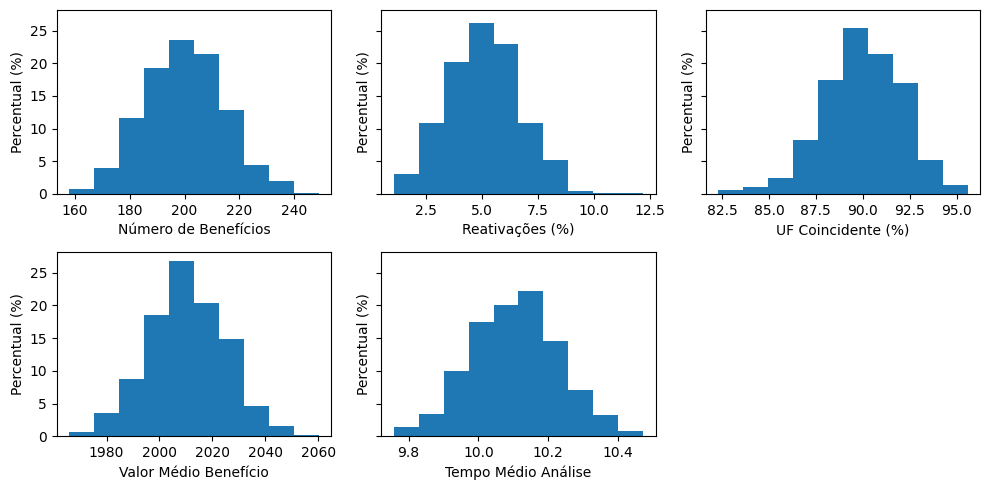

In [ ]:
# prompt: plote as variáveis dos servidores em histogramas, onde o eixo y é o percentual.
# Use subplots 2x3 em formato de grid, compartilhando a mesma escala no eixo y. Tamanho (10,5).
# Não precisa de título.
# Use legendas no eixo x com um texto mais descritivo abreviado, mas sem usar o nome da variável.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the analysis data
analise_servidores = pd.read_csv('analise_servidores.csv')

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5), sharey=True)

# Plot histograms for each variable
axes[0, 0].hist(analise_servidores['num_beneficios'], weights=np.ones(len(analise_servidores)) / len(analise_servidores) * 100)
axes[0, 0].set_xlabel('Número de Benefícios')

axes[0, 1].hist(analise_servidores['percentual_reativado'], weights=np.ones(len(analise_servidores)) / len(analise_servidores) * 100)
axes[0, 1].set_xlabel('Reativações (%)')

axes[0, 2].hist(analise_servidores['percentual_uf_coincidente'], weights=np.ones(len(analise_servidores)) / len(analise_servidores) * 100)
axes[0, 2].set_xlabel('UF Coincidente (%)')

axes[1, 0].hist(analise_servidores['media_valor'], weights=np.ones(len(analise_servidores)) / len(analise_servidores) * 100)
axes[1, 0].set_xlabel('Valor Médio Benefício')

axes[1, 1].hist(analise_servidores['media_tempo'], weights=np.ones(len(analise_servidores)) / len(analise_servidores) * 100)
axes[1, 1].set_xlabel('Tempo Médio Análise')

# Remove the last subplot
axes[1,2].axis('off')


# Set y-axis label for all subplots
for ax in axes.flat:
    ax.set_ylabel('Percentual (%)')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


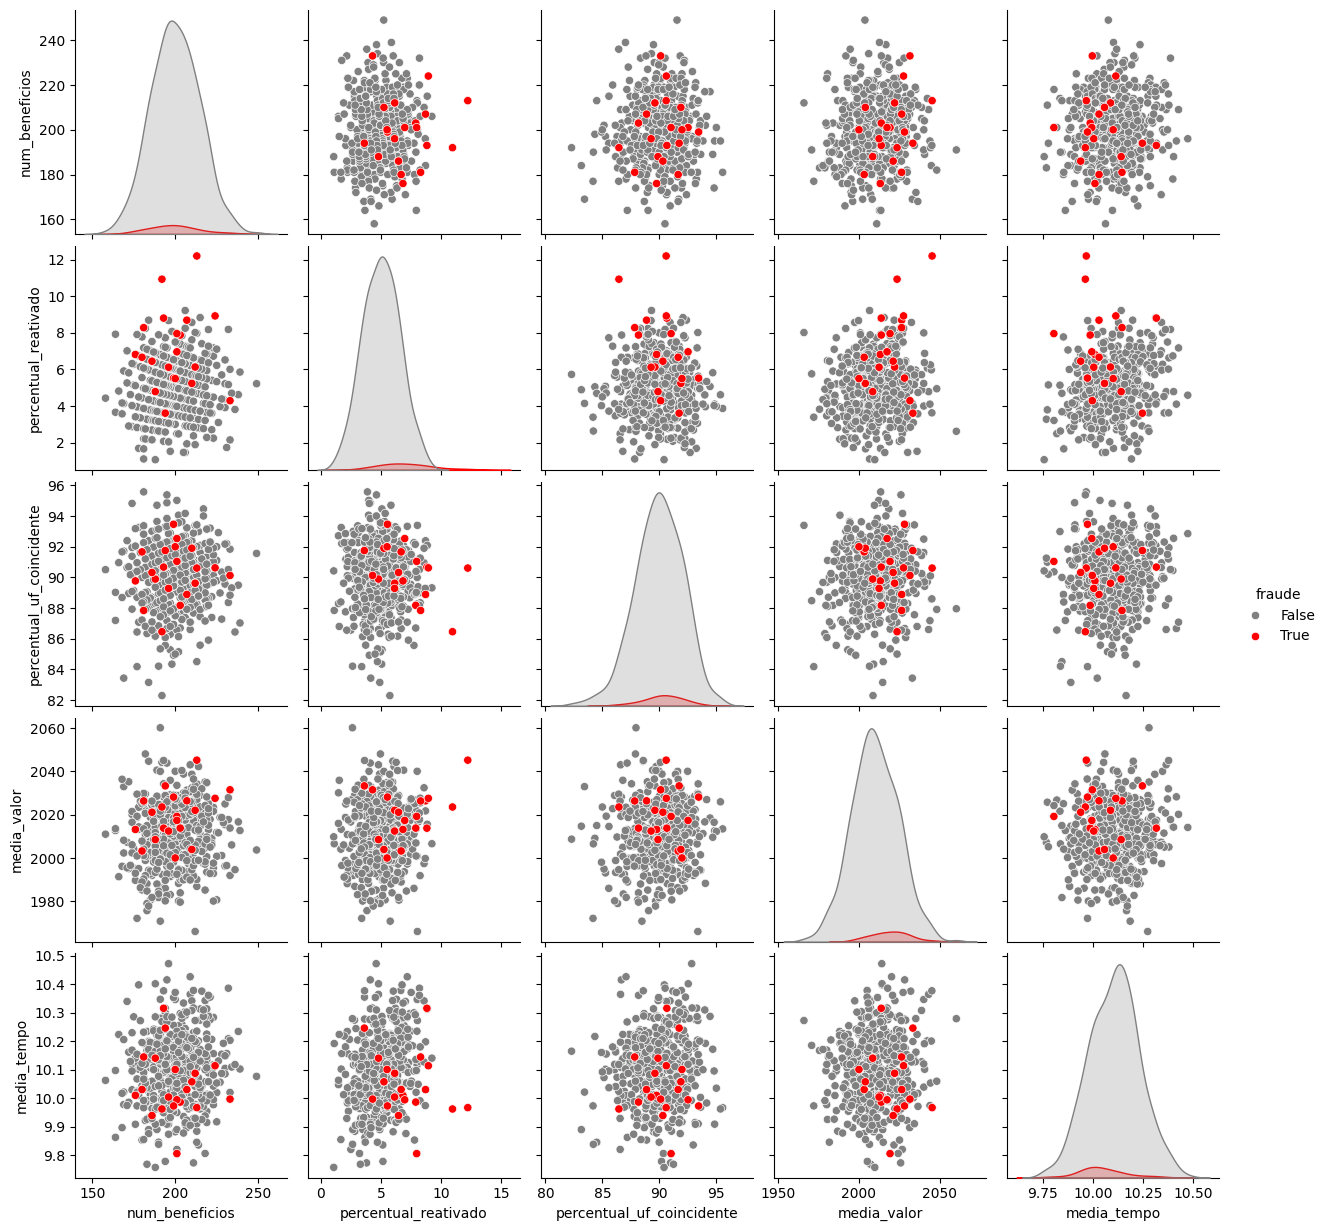

In [ ]:
# prompt: Faça um pairplot entre as 5 variáveis do dataframe dos analise_servidores (não inclua matrícula nem identificadores, se houver).
# Destaque em vermelho os servidores fraudulentos (i.e. que possuem ao menos um benefício fraudado) e em cinza os demais servidores (hue=True/False).
# Ordene o dataframe para que os servidores fraudulentos apareçam por último e, assim, apareçam no gráfico sobre os demais pontos.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the analysis data
analise_servidores = pd.read_csv('analise_servidores.csv')

# Order the DataFrame
analise_servidores = analise_servidores.sort_values('fraude')

# Create the pairplot
sns.pairplot(analise_servidores.drop(columns=['id_servidor']),
             hue='fraude',
             palette={True: 'red', False: 'gray'})

plt.show()


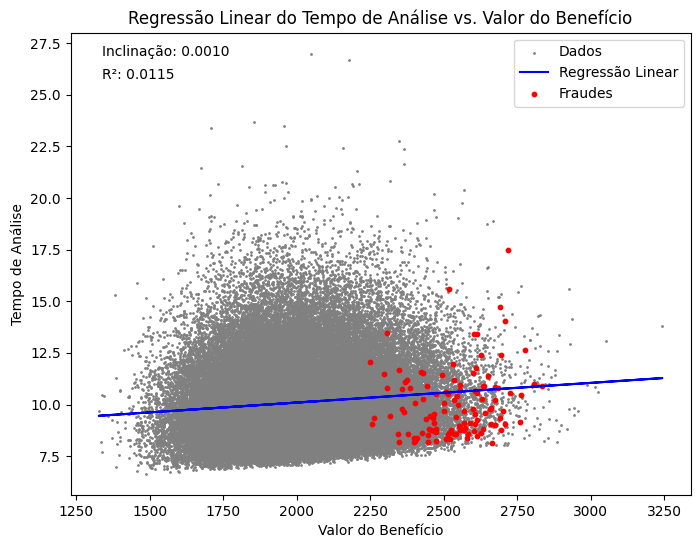

In [ ]:
# prompt: Faça uma regressão linear no beneficios.csv (x:valor_beneficio, y:tempo_analise,).
# Plote a regressão em pontos cinzas (s=1), destacando as fraudes como "círculos" vermelhos (s=10).
# size=(8,6)
# Escreva no gráfico a inclinação e o R2 (4 casas decimais).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the benefits data
beneficios = pd.read_csv('beneficios.csv')

# Prepare the data for linear regression
X = beneficios[['valor_beneficio']].values
y = beneficios['tempo_analise'].values

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R-squared
r_squared = model.score(X, y)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(X, y, s=1, color='gray', label='Dados')

# Plot the regression line
plt.plot(X, model.predict(X), color='blue', label='Regressão Linear')


# Highlight fraudulent cases
fraud_indices = beneficios[beneficios['fraude'] == True].index
plt.scatter(X[fraud_indices], y[fraud_indices], color='red', s=10, marker='o', label='Fraudes')


# Add slope and R-squared to the plot
plt.text(0.05, 0.95, f'Inclinação: {slope:.4f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f'R²: {r_squared:.4f}', transform=plt.gca().transAxes)

# Set plot labels and title
plt.xlabel('Valor do Benefício')
plt.ylabel('Tempo de Análise')
plt.title('Regressão Linear do Tempo de Análise vs. Valor do Benefício')
plt.legend()
plt.show()


<ipython-input-8-a94f948a15b9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['uf_coincidente'] = X['uf_coincidente'].astype(int)
<ipython-input-8-a94f948a15b9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['reativado'] = X['reativado'].astype(int)


   cluster  num_fraudes  cluster_size
1        1            0          4195
6        6            0          5031
5        5            0          5318
9        9            0          7484
3        3            0         13831
4        4            0         16808
8        8            0         20620
0        0            0         21606
7        7            1           499
2        2          113          4608


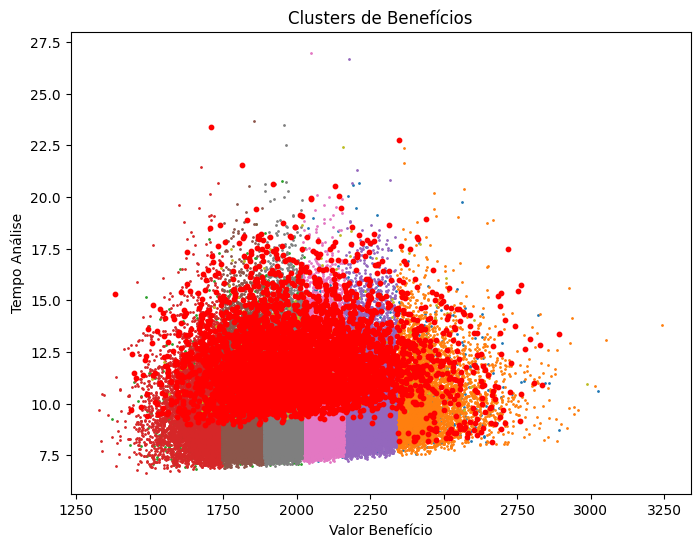

In [ ]:
# prompt: Execute o K-Means com k=10 sobre o beneficios.csv, colunas (uf_coincidente, reativado, valor_beneficio). Normalize os dados (StandardScaler).
# Calcule o número de benefícios fraudados em cada cluster.
# Renumere os clusters de maneira que os clusters com mais fraudes apareçam por último. Em caso de empate, ordene pelo tamanho do cluster em ordem crescente.
# Apresente esse cálculo em um dataframe.
# Plote em um scatter plot 2d (x:valor_beneficio, y:tempo_analise), dots (s=1). O último cluster deve ser vermelho (s=10). Os demai devem possuir cores diferentes, com tonalidades claras.
# size=8,6.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the benefits data
beneficios = pd.read_csv('beneficios.csv')

# Select features for clustering
features = ['uf_coincidente', 'reativado', 'valor_beneficio']
X = beneficios[features]

# Convert boolean features to numerical
X['uf_coincidente'] = X['uf_coincidente'].astype(int)
X['reativado'] = X['reativado'].astype(int)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
beneficios['cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the number of fraudulent benefits in each cluster
fraud_counts = beneficios.groupby('cluster')['fraude'].sum().reset_index()

# Rename columns for clarity
fraud_counts = fraud_counts.rename(columns={'fraude': 'num_fraudes'})

# Calculate cluster sizes
cluster_sizes = beneficios.groupby('cluster')['id_beneficio'].count().reset_index()

# Rename columns for clarity
cluster_sizes = cluster_sizes.rename(columns={'id_beneficio': 'cluster_size'})

# Merge fraud counts and cluster sizes
fraud_analysis = pd.merge(fraud_counts, cluster_sizes, on='cluster')

# Sort clusters
fraud_analysis = fraud_analysis.sort_values(['num_fraudes', 'cluster_size'], ascending=[True, True])

# Renumber clusters based on the new order
new_cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(fraud_analysis['cluster'])}

beneficios['cluster'] = beneficios['cluster'].map(new_cluster_mapping)

#Fraud analysis dataframe
print(fraud_analysis)

# Create the scatter plot
plt.figure(figsize=(8, 6))

for cluster in range(10):
    cluster_data = beneficios[beneficios['cluster'] == cluster]
    if cluster == 9:
      plt.scatter(cluster_data['valor_beneficio'], cluster_data['tempo_analise'], s=10, marker='o', color='red', label=f'Cluster {cluster}')
    else:
      plt.scatter(cluster_data['valor_beneficio'], cluster_data['tempo_analise'], s=1, marker='o', label=f'Cluster {cluster}')

plt.xlabel('Valor Benefício')
plt.ylabel('Tempo Análise')
plt.title('Clusters de Benefícios')
#plt.legend() #Comentado para melhor visualização
plt.show()


In [ ]:
# prompt: Execute algoritmos supervisionados (LogisticRegression, DecisionTree, RandomForest, AdaBoost, GradientBoosting, Ensamble(de todos os outros algoritmos)). Use weights="balanced" quando possível.
# Use os dados do beneficios.csv. Não use identificadores ou matrículas. Separe 20% para teste. Não treine com dados de teste.
# Colete, para cada algoritmo, o resultado em um dicionário "matrizes_de_confusao" contendo a matriz de confusão, para posterior uso. Imprima o andamento da execução, com um print da matriz de cada algoritmo executado.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the benefits data
beneficios = pd.read_csv('beneficios.csv')

# Prepare data
X = beneficios[['uf_coincidente', 'reativado', 'valor_beneficio', 'tempo_analise']]
y = beneficios['fraude']

# Convert boolean features to integers
X['uf_coincidente'] = X['uf_coincidente'].astype(int)
X['reativado'] = X['reativado'].astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize algorithms
algorithms = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

# Ensemble classifier
estimators = [
    ('lr', LogisticRegression(class_weight='balanced')),
    ('dt', DecisionTreeClassifier(class_weight='balanced')),
    ('rf', RandomForestClassifier(class_weight='balanced')),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
]
ensemble = VotingClassifier(estimators=estimators, voting='hard') #voting='soft' if probabilities available

algorithms['Ensemble'] = ensemble

# Store confusion matrices
matrizes_de_confusao = {}

# Train and evaluate each algorithm
for name, algo in algorithms.items():
    print(f"Training {name}...")
    algo.fit(X_train, y_train)
    y_pred = algo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    matrizes_de_confusao[name] = cm
    print(f"Confusion Matrix for {name}:\n{cm}")


<ipython-input-12-ad54bb917fc0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['uf_coincidente'] = X['uf_coincidente'].astype(int)
<ipython-input-12-ad54bb917fc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['reativado'] = X['reativado'].astype(int)


Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for Logistic Regression:
[[19826   148]
 [    0    26]]
Training Decision Tree...
Confusion Matrix for Decision Tree:
[[19969     5]
 [   11    15]]
Training Random Forest...
Confusion Matrix for Random Forest:
[[19971     3]
 [   10    16]]
Training AdaBoost...
Confusion Matrix for AdaBoost:
[[19970     4]
 [   10    16]]
Training Gradient Boosting...
Confusion Matrix for Gradient Boosting:
[[19971     3]
 [   11    15]]
Training Ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for Ensemble:
[[19971     3]
 [    8    18]]


In [ ]:
# prompt: Use as matrizes salvas no dicionario e faça um dataframe "resultado" com o resultado de precision, recall e f1-score de cada algoritmo

import pandas as pd
# Create an empty list to store the results
results = []

# Iterate through the confusion matrices
for name, cm in matrizes_de_confusao.items():
    # Extract true positive, true negative, false positive, and false negative from the confusion matrix
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Append the results to the list
    results.append([name, precision, recall, f1_score])

# Create the results DataFrame
resultado = pd.DataFrame(results, columns=['Algoritmo', 'Precisão', 'Recall', 'F1-Score'])

# Display the results
resultado


,Algoritmo,Precisão,Recall,F1-Score
0,Logistic Regression,0.149425,1.000000,0.260000
1,Decision Tree,0.750000,0.576923,0.652174
2,Random Forest,0.842105,0.615385,0.711111
3,AdaBoost,0.800000,0.615385,0.695652
4,Gradient Boosting,0.833333,0.576923,0.681818
5,Ensemble,0.857143,0.692308,0.765957


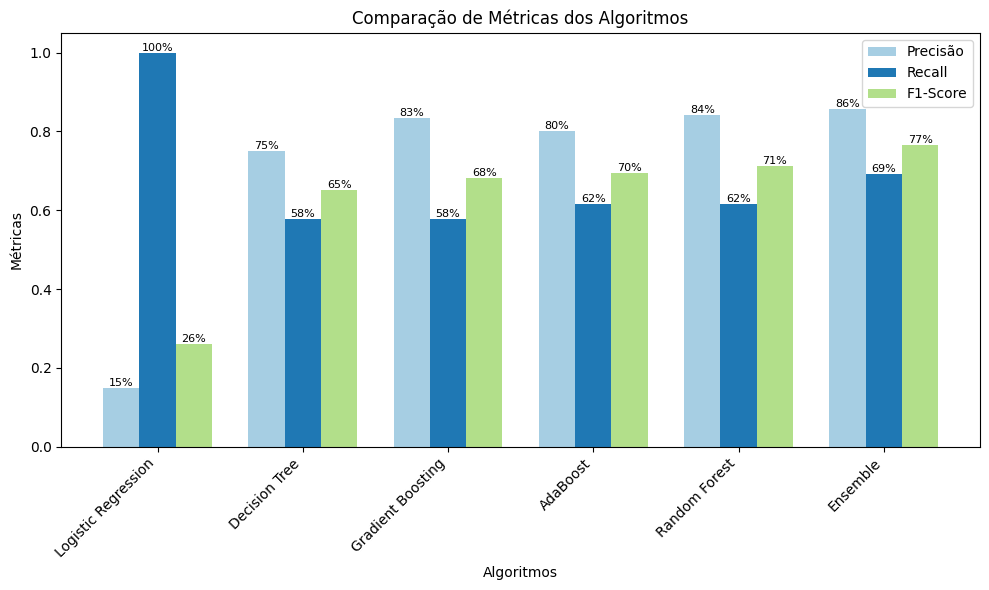

In [ ]:
# prompt: Plote o resultado com um gráfico de barras vertical agrupados, apresentando as métricas de precision, recall e f1-score para cada algoritmo. Ordene-os pelo f1-score. Use cores distintas e suaves para cada métrica. Coloque o valor da métrica % (sem casas decimais) em cima de cada barra. size=(10,6)

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'resultado' DataFrame is already created as in the previous code

# Sort the DataFrame by F1-Score
resultado = resultado.sort_values('F1-Score')

# Create the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(resultado))

# Define colors
colors = ['#a6cee3', '#1f78b4', '#b2df8a']

# Plot the bars
rects1 = ax.bar(index, resultado['Precisão'], bar_width, color=colors[0], label='Precisão')
rects2 = ax.bar(index + bar_width, resultado['Recall'], bar_width, color=colors[1], label='Recall')
rects3 = ax.bar(index + 2 * bar_width, resultado['F1-Score'], bar_width, color=colors[2], label='F1-Score')

# Add labels and annotations
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height,
                f'{height * 100:.0f}%',
                ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


# Set x-axis labels
ax.set_xticks(index + bar_width)
ax.set_xticklabels(resultado['Algoritmo'], rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Algoritmos')
ax.set_ylabel('Métricas')
ax.set_title('Comparação de Métricas dos Algoritmos')
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


<ipython-input-22-b485afec1ddb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['uf_coincidente'] = X['uf_coincidente'].astype(int)
<ipython-input-22-b485afec1ddb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['reativado'] = X['reativado'].astype(int)


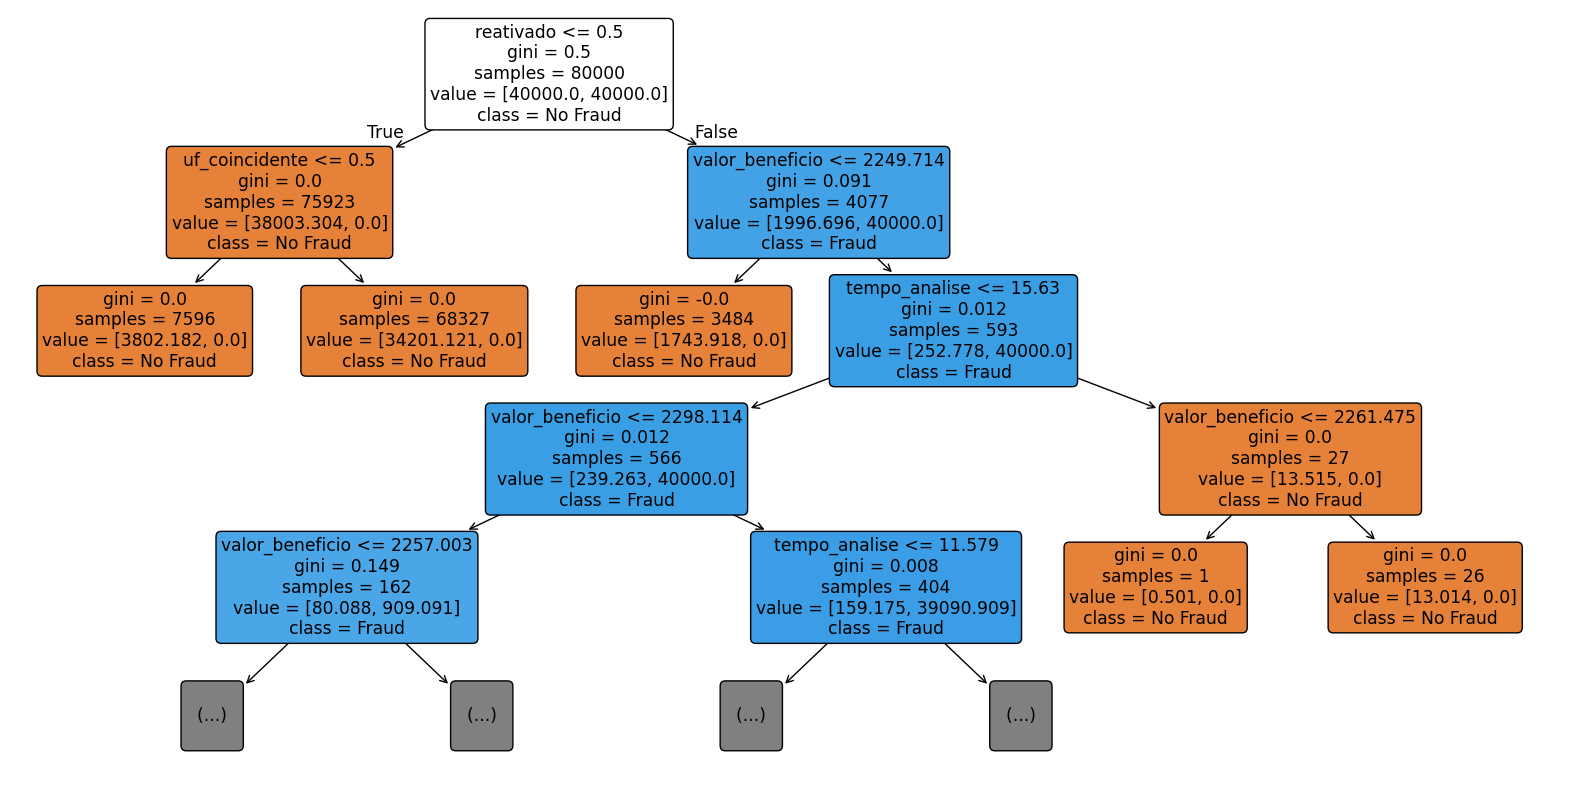

In [ ]:
              # prompt: Desenhe a árvore de decisão, conforme trenado anteriormente, com os mesmos parametros. No desenho, mostre apenas os primeiros 4 níveis.

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the benefits data
beneficios = pd.read_csv('beneficios.csv')

# Prepare data
X = beneficios[['uf_coincidente', 'reativado', 'valor_beneficio', 'tempo_analise']]
y = beneficios['fraude']

# Convert boolean features to integers
X['uf_coincidente'] = X['uf_coincidente'].astype(int)
X['reativado'] = X['reativado'].astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_classifier.fit(X_train, y_train)

# Plot the decision tree with max_depth=4
plt.figure(figsize=(20,10))
plot_tree(dt_classifier,
          max_depth=4,
          feature_names=X.columns,
          class_names=['No Fraud', 'Fraud'],
          filled=True,
          rounded=True)
plt.show()
